In [ ]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import torchvision 
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
DATA_PATH = '/content/Flower'
# batch_size=64
# train_ = torchvision.datasets.Flowers102(root = data_path, download = True)
# train_batch= DataLoader(dataset= train_, batch_size = 64, shuffle= True)
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128)),transforms.Grayscale(num_output_channels=1)])#grayscale 1 channels
trans1 = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128))])#colored 3 channels
trans2 = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128)),transforms.Grayscale(num_output_channels=3)])#grayscale 3 Channels
# train_dataset = torchvision.datasets.Flowers102(root=DATA_PATH, transform=trans1, download=True)

train_dataset_org = torchvision.datasets.Flowers102(root=DATA_PATH, transform=trans1, download=True)
# train and test set are same here
CUDA_LAUNCH_BLOCKING=1

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting /content/Flower/flowers-102/102flowers.tgz to /content/Flower/flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

In [ ]:
from skimage.io import imread
import skimage.color as color
from skimage.color import rgb2lab, lab2rgb,rgb2gray

In [ ]:
# Method-I to convert graycale to RGB
def dataset_lab(cls, resize):
    def __getitem__(self, index):
        pil_image, target = cls.__getitem__(self, index)
        pil_image = resize(pil_image)
        lab_image = color.rgb2lab(pil_image)
        img = torch.from_numpy(lab_image).permute(2,0,1)
        return img[0].unsqueeze(0) / 100, img[1:] / 128, target
    return type(
        cls.__name__,
        (cls,),
        {
            "__getitem__": __getitem__,
        }
    )

train_dataset_lab=dataset_lab( torchvision.datasets.Flowers102 , transforms.Resize((256,256)))
DATA_PATH1="./Flower_lab"
train_loader = torch.utils.data.DataLoader(DATA_PATH1 ,batch_size=32)


In [ ]:
# Method-II to convert graycale to RGB
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target


In [ ]:
# Dataset for grascale image to rgb
train_transform=transforms.Resize((256,256))
train_image = GrayscaleImageFolder(DATA_PATH  , train_transform)

In [ ]:
train_loader = DataLoader(train_image, batch_size=64, shuffle=False)



In [ ]:
from torchvision import models
from torchsummary import summary


# How to take Resnet
class NET(nn.Module):
  def __init__(self):
    super(NET,self).__init__()
    mf= 128

    resnet = models.resnet18(1,32) 
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    self.decoder=nn.Sequential(nn.Conv2d(mf, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2),
      nn.Sigmoid())
    
  def forward(self,x):
      # x=self.conv_encoder(x)
      resnet_x=self.midlevel_resnet(x)
      output=self.decoder(resnet_x)
      
      return output



# model = models.resnet18()
# summary(model,(3,256,256),32)

In [ ]:
loss_fn = torch.nn.MSELoss()
lr= 0.001
net=NET()
for params in net.midlevel_resnet.parameters():
  params.requires_grad=False
# params_to_optimize = [
#     {'params': net.parameters()}
# ]
#
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
net.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' and 'progress' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Selected device: cuda


NET(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
# print(train_loader[0].size)

train_loss = []

In [ ]:
net.train()
i=0
# for i in range(1):
for (train_image,test_image,_)  in (train_loader) : 
# for train_image,test_image,_  in train_image : 
    
      train_image = train_image.to(device)
      test_image=test_image.to(device)
      # output=torch.from_numpy(output)
      # output=output.to(device)
      output= net(train_image)
      
      # Evaluate loss
      loss = loss_fn(output, test_image)
  #     # Backward pass
      i=i+1
      print(i)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  #   # Print batch loss
    
      # print('\t partial train loss (single batch): %f' % (loss.data))
      # train_loss.append(loss.detach().cpu().numpy())
# print(i)


In [ ]:
train_image=train_image.cpu().detach().numpy()


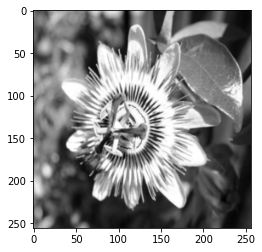

In [ ]:
plt.imshow(train_image[1].reshape(256,256),cmap="gray")

In [ ]:
test_image=test_image.cpu().detach().numpy()

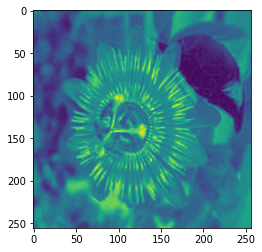

In [ ]:
# test_image=test_image.cpu().detach().numpy()
plt.imshow(test_image[1][0])

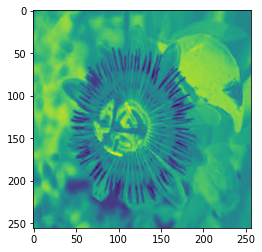

In [ ]:
plt.imshow(test_image[1][1])

In [ ]:
output=output.cpu().detach().numpy()

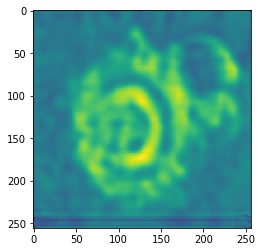

In [ ]:
plt.imshow(output[1][0])

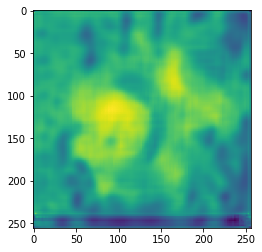

In [ ]:
plt.imshow((output[1][1]))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name='img_color_Lab_2.pth'
PATHd=f"/content/gdrive/MyDrive/{model_save_name}"
torch.save(net.state_dict(), PATHd)

In [ ]:
# model_save_name='img_color_NET.pth'
# model=torch.load(model_save_name)
# model.eval()

net=NET()
net.load_state_dict(torch.load('/content/gdrive/MyDrive/img_color_Lab_1.pth',map_location=torch.device('cpu')))
net.to(device)

NET(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
plt.plot(train_loss)

In [ ]:
output=torch.from_numpy(output)
train_image=torch.from_numpy(train_image)

In [ ]:
print(type(output))
print(type(train_image))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
# print(type(train_image[0][0]))
print(torch.max(output[0]))
print(torch.max(train_image[0]))

In [ ]:
# Concatinating L and AB channel then converting it to RGB form
color_image = torch.cat((train_image[20].cpu(), output[20].detach().cpu()), 0).numpy() # combine channels
color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
color_image[:, :, 0:1] = color_image[:, :, 0:1] *100
color_image[:, :, 1:3] = color_image[:, :, 1:3] *255 -128

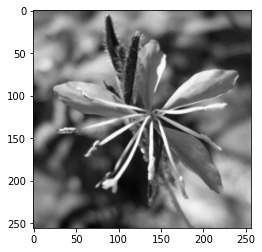

In [ ]:
I=train_image[20].cpu().numpy()
plt.imshow(I.reshape(256,256),cmap='gray')

In [ ]:
color_image = lab2rgb(color_image.astype(np.float64))

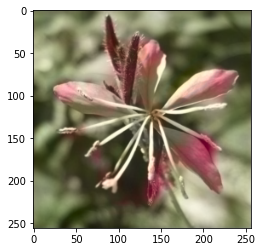

In [ ]:
plt.imshow(color_image)

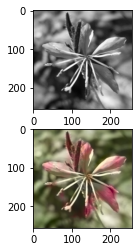

In [ ]:
plt.clf
plt.subplot(2,1,1)
# title("")
plt.imshow(I.reshape(256,256),cmap="gray")
plt.subplot(2,1,2)
plt.imshow(color_image)

In [ ]:
# For evaluation/testing purpose

net.eval()

# for i in range(1):
for train_image,test_image,_  in train_loader : 
# for train_image,test_image,_  in train_image : 
      train_image = train_image.to(device)
      test_image=test_image.to(device)
      # output=torch.from_numpy(output)
      # output=output.to(device)
      output= net(train_image)
      break
